In [197]:
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import shapely
from markupsafe import soft_str
import folium

from scipy.spatial import Voronoi, voronoi_plot_2d

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# Библиотека geovoronoi

In [188]:
# Загружаем границы Санкт-Петербурга, избавляемся от линий и точек, оставляем только полигоны
boundary = gpd.read_file("Спб.geojson")
boundary = boundary[~boundary['id'].str.contains('node')]
boundary = boundary[~boundary['id'].str.contains('way')]
boundary

,id,@id,CEMT,access,addr:country,addr:region,addr:suburb,admin_level,alt_name,amenity,...,url,usage,vehicle,voltage,waterway,width,wikidata,wikipedia,@relations,geometry
0,relation/337424,relation/337424,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q1326302,ru:Колпинский район,None,"POLYGON ((30.62998 59.73581, 30.64069 59.72772..."
1,relation/338635,relation/338635,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q220316,ru:Пушкинский район (Санкт-Петербург),None,"POLYGON ((30.55564 59.73684, 30.55599 59.73739..."
2,relation/338636,relation/338636,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q270112,ru:Московский район (Санкт-Петербург),None,"POLYGON ((30.24885 59.82347, 30.24878 59.82342..."
3,relation/363103,relation/363103,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q270124,ru:Красносельский район (Санкт-Петербург),None,"MULTIPOLYGON (((30.06506 59.66830, 30.07331 59..."
4,relation/367375,relation/367375,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q270114,ru:Петродворцовый район,None,"MULTIPOLYGON (((30.04477 59.86349, 30.04490 59..."
5,relation/368287,relation/368287,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q1193156,ru:Невский район,None,"POLYGON ((30.49554 59.89201, 30.50002 59.91079..."
6,relation/369514,relation/369514,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q1142777,ru:Фрунзенский район (Санкт-Петербург),None,"POLYGON ((30.33813 59.90499, 30.33846 59.90502..."
7,relation/1114193,relation/1114193,None,None,None,Санкт-Петербург,None,5,None,None,...,http://www.gov.spb.ru/law?d&nd=8414528&nh=0&he...,None,None,None,None,None,Q219746,ru:Адмиралтейский район,None,"POLYGON ((30.31841 59.90864, 30.31950 59.90864..."
8,relation/1114252,relation/1114252,None,None,RU,Санкт-Петербург,None,5,None,None,...,http://www.gov.spb.ru/law?d&nd=8414528&nh=0&he...,None,None,None,None,None,Q220622,ru:Василеостровский район,None,"POLYGON ((30.25185 59.92038, 30.25167 59.92023..."
9,relation/1114354,relation/1114354,None,None,RU,Санкт-Петербург,None,5,None,None,...,None,None,None,None,None,None,Q219907,ru:Выборгский район (Санкт-Петербург),None,"POLYGON ((30.12618 60.05632, 30.13563 60.05761..."


In [183]:
# Загружаем сотовые вышки, это точечный слой
gdf = gpd.read_file("Сотовые вышки спб.geojson")
gdf.head()

,id,@id,colour,communication:2G,communication:3G,communication:4G,communication:4G+,communication:5G,communication:amateur_radio,communication:microwave,...,ownership,power,ref,source,start_date,tower:construction,tower:type,width,wikidata,geometry
0,node/599311404,node/599311404,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,communication,None,Q4387529,POINT (30.35503 59.96327)
1,node/727663900,node/727663900,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,communication,None,None,POINT (30.47469 59.87462)
2,node/727663992,node/727663992,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,communication,None,None,POINT (30.47236 59.87594)
3,node/727664216,node/727664216,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,communication,None,None,POINT (30.47339 59.87540)
4,node/727664234,node/727664234,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,communication,None,None,POINT (30.46570 59.87791)


In [189]:
# Меняем проекцию на UTM 36N
boundary = boundary.to_crs(epsg=32636)
gdf = gdf.to_crs(boundary.crs)

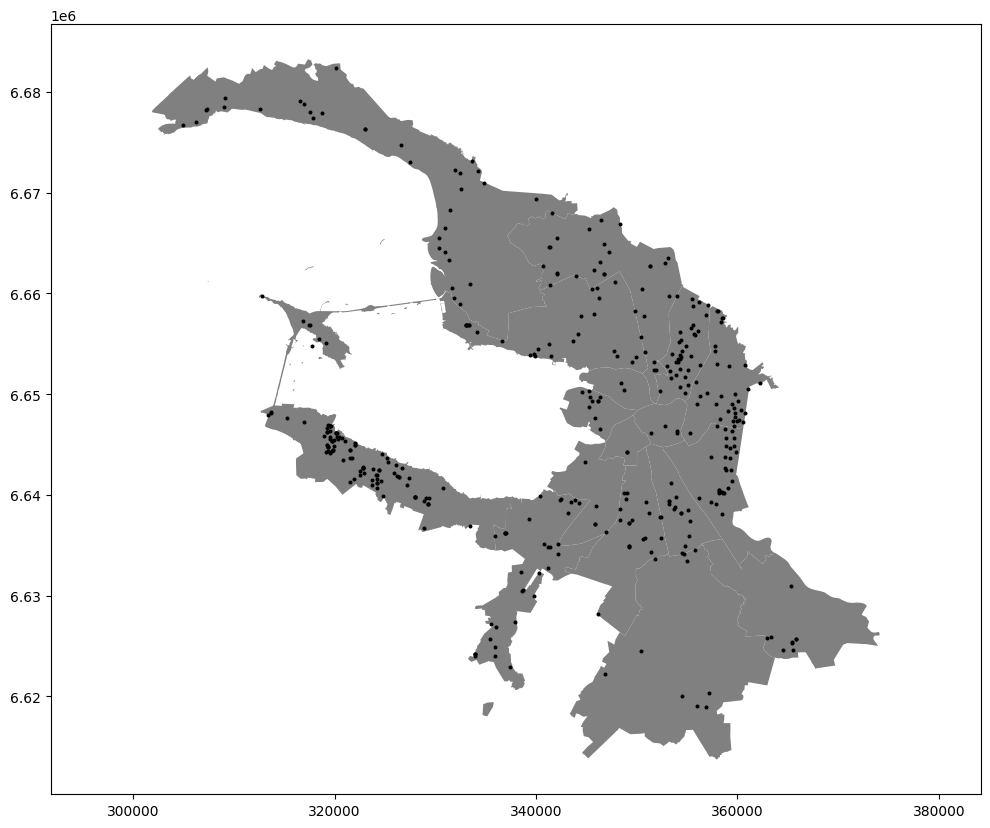

In [190]:
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="gray")
gdf.plot(ax=ax, markersize=3.5, color="black")
plt.axis('equal')
plt.show()

In [191]:
# Объединяем полигоны районов Спб в один мультиполигон
union_boundary = boundary['geometry'].unary_union

In [195]:
# Задаем координаты и полигоны для диаграммы Вороного
coords = points_to_coords(gdf.geometry)
region_polys, region_pts = voronoi_regions_from_coords(coords, union_boundary)

/home/ertsegovats/.local/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/ertsegovats/.local/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


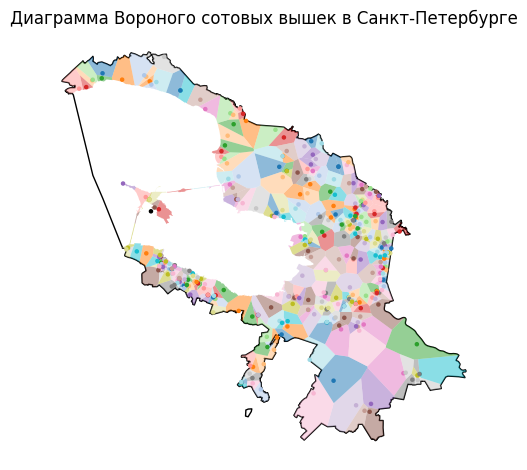

In [196]:
# Визуализируем
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)

ax.set_title('Диаграмма Вороного сотовых вышек в Санкт-Петербурге')

plt.tight_layout()
plt.show()

# Библиотека scipy

In [198]:
# Преобразовываем геометрию gdf сотовых вышек в массив
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
x = np.asarray(coord_list)

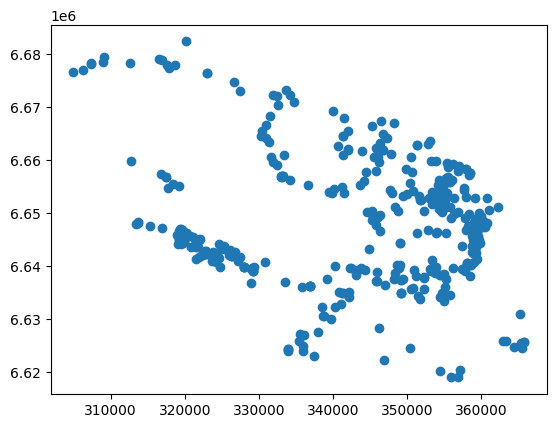

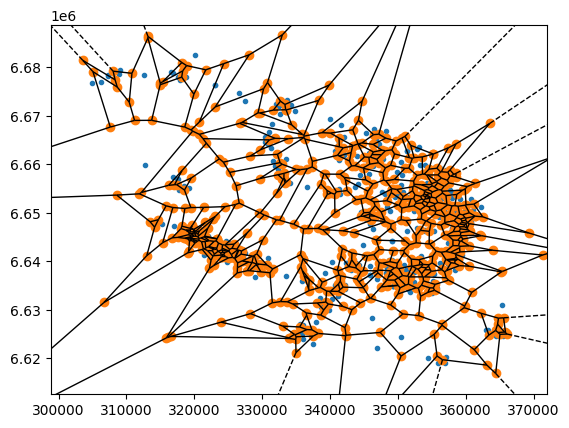

In [199]:
# Задаем коордианты и полигоны для диаграммы Вороного и визуализируем
vor2 = Voronoi(x)
plt.scatter(x[:,0], x[:,1])

fig2 = voronoi_plot_2d(vor2)
plt.show()